In [1]:
import pandas as pd
import numpy as np
from matplotlib.pylab import rcParams
import seaborn as sns
import sys
from utils import *

In [2]:
nt = 'compute_haswell'
slot = 3  # length of the interval in hours for resampling

test_size = 0.3
time_range = (pd.Timestamp(2018, 1, 1), pd.Timestamp(2021, 7, 1))

In [3]:
hisotry = select_data('compute_haswell.csv', time_range)
plot_rsrc(hisotry, 'compute_haswell')

## Step 1. Resample by a time slot

Counting the number of nodes assigned to Chameleon users within a fixed time interval.

In [4]:
node_data = resample_sum(hisotry, slot)
node_data.dropna(inplace=True)
plot_rsrc(node_data, nt)

In [5]:
node_data.set_index(['start_on'], inplace=True)

In [6]:
actual_train, actual_test = train_test_split(node_data, test_size=test_size, shuffle=False)

## Step 2. Smooth dataset

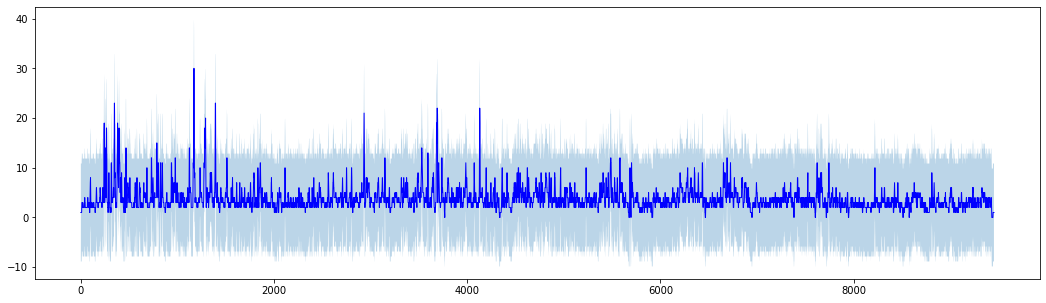

In [7]:
smoother = lowess_smoother(node_data)
# generate intervals
low, up = smoother.get_intervals('sigma_interval')
# plot the smoothed timeseries with intervals
plt.figure(figsize=(18,5))
plt.plot(smoother.smooth_data.squeeze(), linewidth=1, color='blue')
plt.fill_between(range(len(smoother.data.squeeze())), low[0], up[0], alpha=0.3)
plt.show()

In [8]:
node_data['node_cnt'] = smoother.smooth_data.squeeze()

## Step 3. Stationarity(ADF) Test
### Compute the firt order difference if timeseries is non-stationary

In [9]:
results = test_stationarity(node_data.node_cnt)

                                   value
Test Statistic Value            -11.7099
p-value                      1.49756e-21
Lags Used                             34
Number of Observations Used         9418
Critical Value(1%)              -3.43104
Critical Value(5%)              -2.86185
Critical Value(10%)             -2.56693


In [10]:
do_fod = False
if results['value']['Test Statistic Value'] > results['value']['Critical Value(1%)']:
    node_data_diff = node_data.shift(1)
    node_data.node_cnt = node_data.node_cnt - node_data_diff.node_cnt
    node_data = node_data.dropna()
    plot_rsrc(node_data, nt)
    do_fod = True

In [11]:
if do_fod:
    test_stationarity(node_data.node_cnt)

## Step 4. Determine the optimal order(p, q) using AIC

In [34]:
pq = sm.tsa.arma_order_select_ic(node_data.node_cnt, max_ar=10, max_ma=10, ic='aic', trend='c')['aic_min_order']
pdq = (pq[0], int(do_fod), pq[1])
print('ARMA(p,q) =',pq,'is the best.')

ARMA(p,q) = (8, 5) is the best.


## Step 5. Determine seasonal_order(sp,sd,sq,s) 

parameter s:
- 1 for yearly
- 4 for quarterly
- 12 for monthly
- 52 for weekly
- 365 for daily

In [35]:
def get_ARIMA_params(data, pdq, s):
    p = d = q = range(0, 3)
    seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(p, d, q))]
    score_aic = 1000000.0
    warnings.filterwarnings("ignore") # specify to ignore warning messages
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(data,
                                        order=pdq,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        results = mod.fit()
        if results.aic < score_aic:
            score_aic = results.aic
            params = param_seasonal, results.aic
    param_seasonal, results.aic = params
    print('x{}12 - AIC:{}'.format(param_seasonal, results.aic))
    return param_seasonal

seasonal_order = get_ARIMA_params(node_data.node_cnt, pdq, 12)

x(2, 0, 0, 12)12 - AIC:9752.630857150882


## Step 6. Build SARIMAX Model

In [36]:
def model_forecast(train, test_start, test_end):
    mod = sm.tsa.statespace.SARIMAX(train.node_cnt,
                                    order=pdq,
                                    seasonal_order=seasonal_order,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    mod_fit = mod.fit()
    summary = mod_fit.summary()
    rlt = mod_fit.predict(test_start, test_end)
    return rlt.to_frame()

def forward_valid(data, steps):
    predictions = pd.DataFrame([])
    start_on = data.index
    train_end = int(data.shape[0] * 0.8)
    test_start = train_end
    test = data.iloc[test_start:]
    while test_start+steps < len(start_on):
        pred = model_forecast(data.iloc[:train_end], start_on[test_start], start_on[test_start+steps])
        predictions = predictions.append(pred)
        train_end = train_end + steps
        test_start = train_end
    predictions.index.name = 'start_on'
    predictions = predictions.join(test).dropna()
    predictions = predictions[~predictions.index.duplicated(keep='last')]
    error = rmse(predictions.predicted_mean, predictions.node_cnt)
    return predictions, error

predictions_results, error = forward_valid(node_data, 7)

In [38]:
plot_trace(predictions_results, ['predicted_mean', 'node_cnt'])

In [39]:
print('RMSE: ', error)

RMSE:  11.018063092892152
